# Marketing Funnel Analysis with Logistic Regression & Chi-Square Test
This notebook walks through:
- Cleaning and preparing marketing data
- Visualizing funnel stages
- Running Logistic Regression to find registration drivers
- Performing a Chi-Square test of independence
- (Optional) Loading data into a warehouse

In [ ]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from scipy.stats import chi2_contingency

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load and Prepare Data
At this step we are approaching the processes below:

- Load the Dataset
- Clean Column Names
- Convert Timestamps
- Create Opt-out Indicator
- Fill Missing Data
- Create Registration Flag
- Derive Job Role Category
- Assign Funnel Stage Index
- Save the Curated Dataset

In [ ]:
# Mounting drive
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load dataset and standardize column names
df = pd.read_excel("/content/drive/MyDrive/Notebooks/Accenture/use-case-mkt-04-05-2025/analytics-case-study-data 8.xlsx")
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

Index(['campaign_id', 'campaign_name', 'prospect_status', 'account_id',
       'account_name', 'domain', 'country', 'prospect_id', 'opt-in',
       'opt-in_source', 'opt-in_timestamp', 'opt-out_timestamp', 'job_title',
       'prospect_source'],
      dtype='object')

# Exploratory Data Analysis (EDA)

Exploratory Data Analysis helps understand the structure, patterns, and quality of the dataset before any modeling or advanced analytics.

In [ ]:
#Checking duplicates
duplicates = df[df.duplicated()]
print(f"Number of duplicate rows: {len(duplicates)}")

Number of duplicate rows: 0


## 1. Initial Dataset Inspection

**Goal:** Understand the shape, data types, and basic structure.

*  Python
  * df.shape: number of rows and columns  
  * df.columns: column names  
  * df.isnull: null data  
  * df.unique: data uniqueness by column

* Statistics by columns

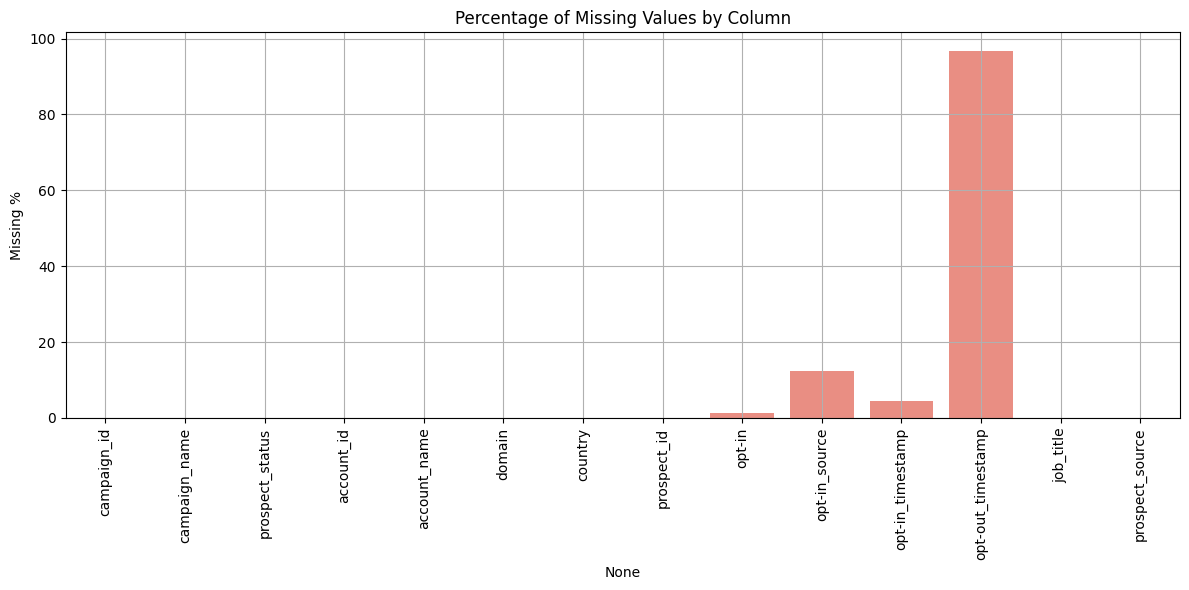

<ipython-input-9-3401608329>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=summary.index, y="Unique Values", data=summary, palette="coolwarm")


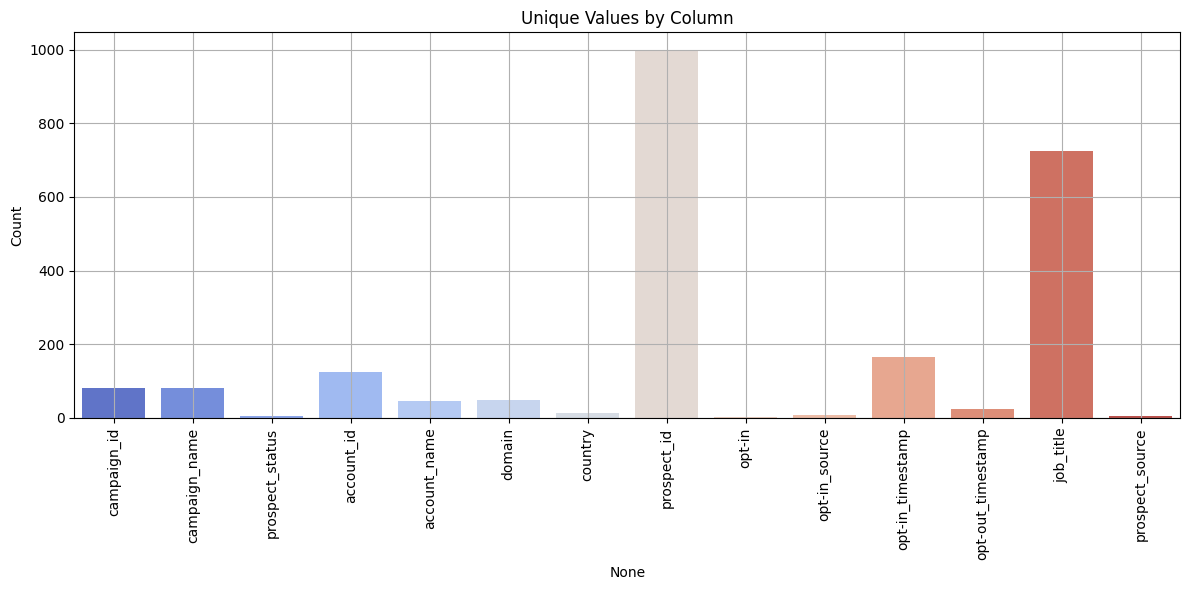

In [ ]:
def generate_column_summary(df):
    summary = pd.DataFrame({
        "Data Type": df.dtypes,
        "Missing (%)": df.isnull().mean() * 100,
        "Unique Values": df.nunique(),
        "Sample Value": df.apply(lambda x: x.dropna().unique()[:3])
    })

    return summary

def plot_column_summary(summary):
    plt.figure(figsize=(12, 6))
    sns.barplot(x=summary.index, y="Missing (%)", data=summary, color="salmon")
    plt.xticks(rotation=90)
    plt.title("Percentage of Missing Values by Column")
    plt.ylabel("Missing %")
    plt.tight_layout()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.barplot(x=summary.index, y="Unique Values", data=summary, palette="coolwarm")
    plt.xticks(rotation=90)
    plt.title("Unique Values by Column")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.grid(True)
    plt.show()

summary = generate_column_summary(df)
plot_column_summary(summary)

## Outliers
Check outliers by column

In [ ]:
from scipy.stats import zscore

numeric_cols = df.select_dtypes(include='number')
z_scores = numeric_cols.apply(zscore)
outliers = (z_scores.abs() > 3).sum()
print("Potential outliers per column:")
print(outliers)

## Data uniqueness detailed
### Top 10 values by key columns
This statistics intend to describe the uniqueness and, also, the relation between key columns and the data provided

<ipython-input-10-218994046>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, ax=ax, palette="viridis")
<ipython-input-10-218994046>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, ax=ax, palette="viridis")
<ipython-input-10-218994046>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, ax=ax, palette="viridis")
<ipython-input-10-218994046>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprec

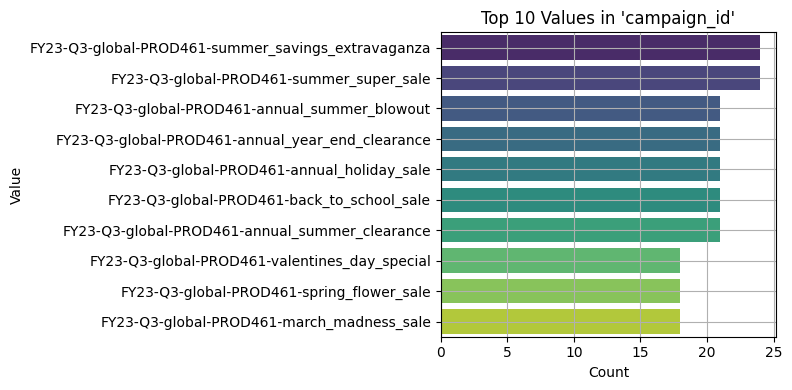

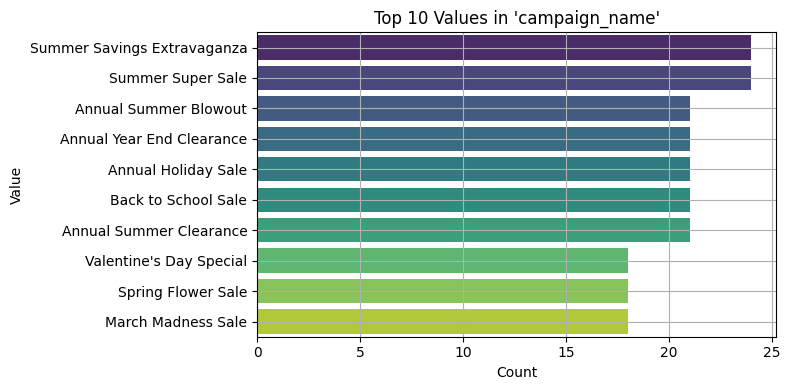

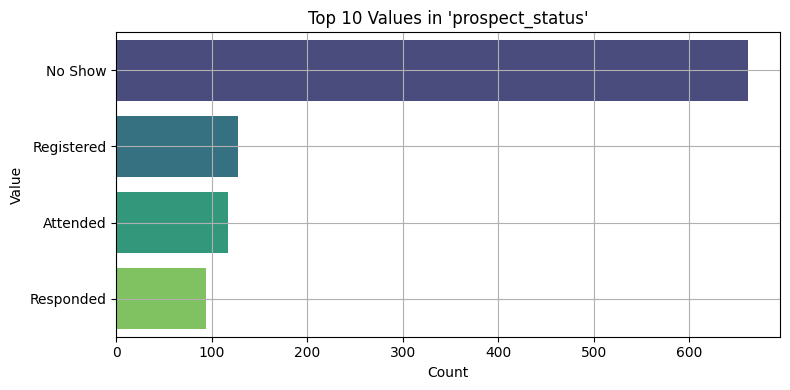

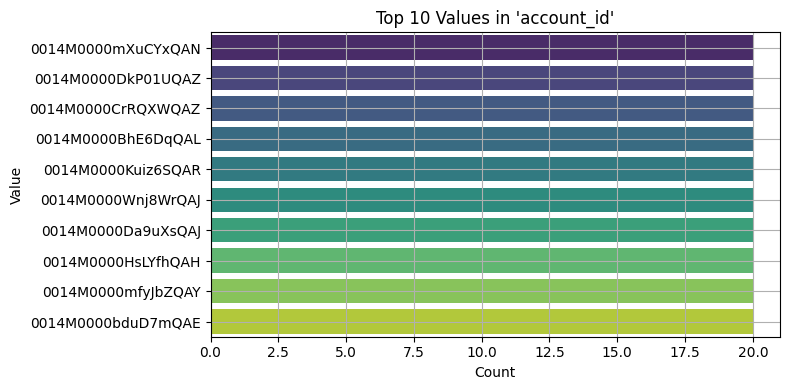

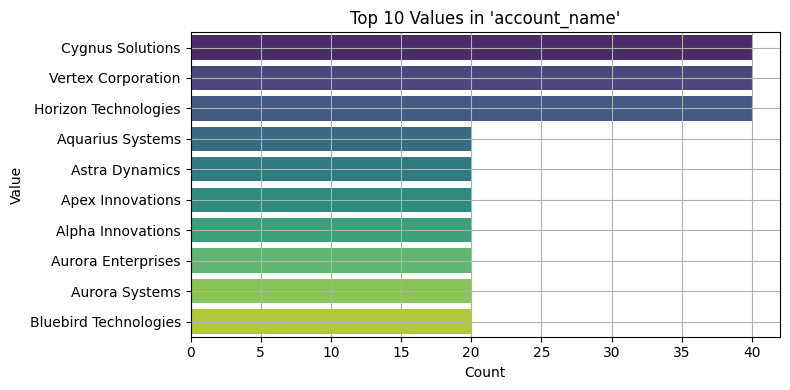

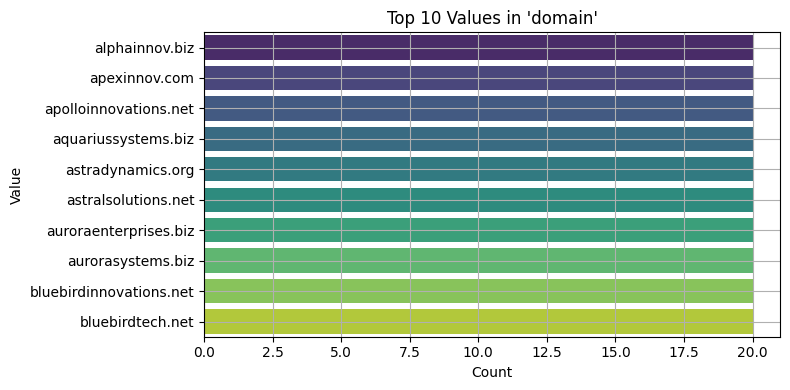

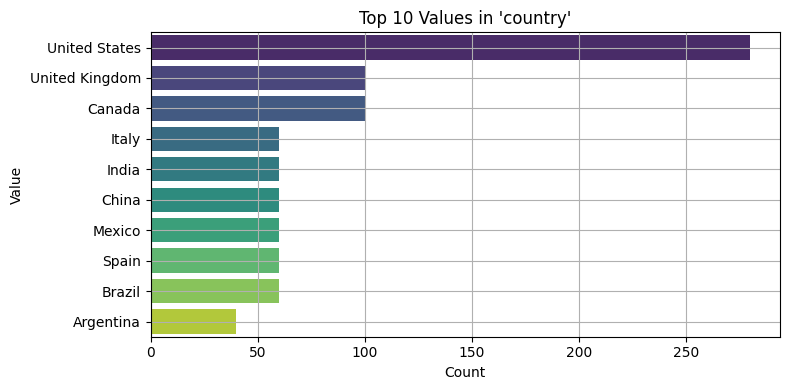

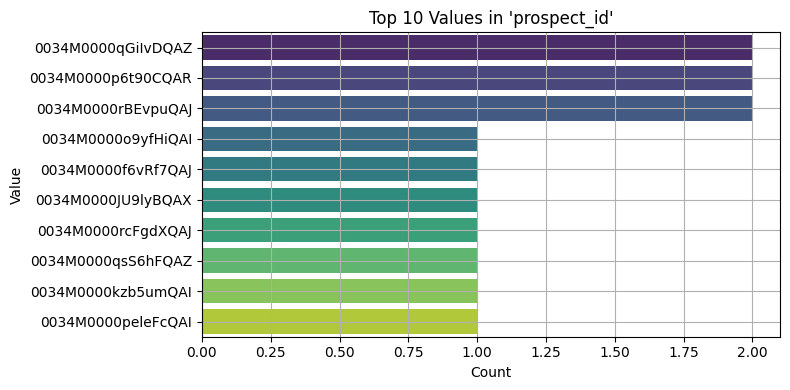

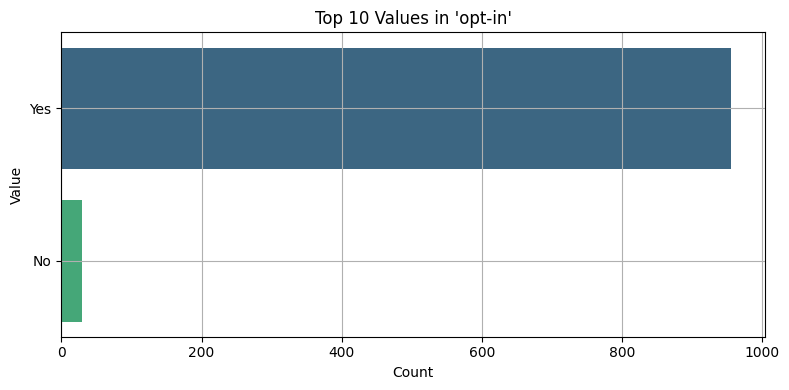

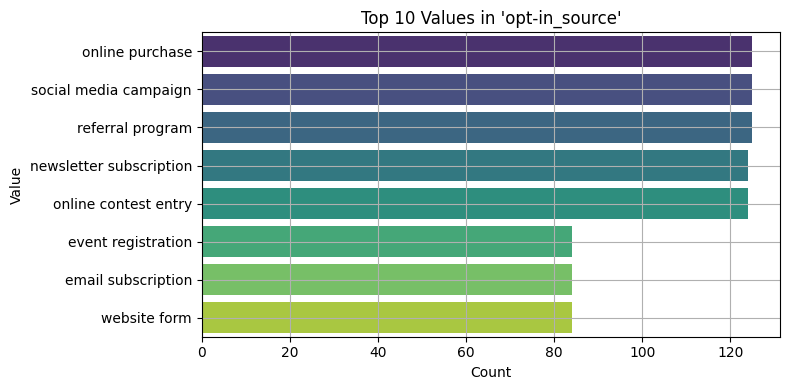

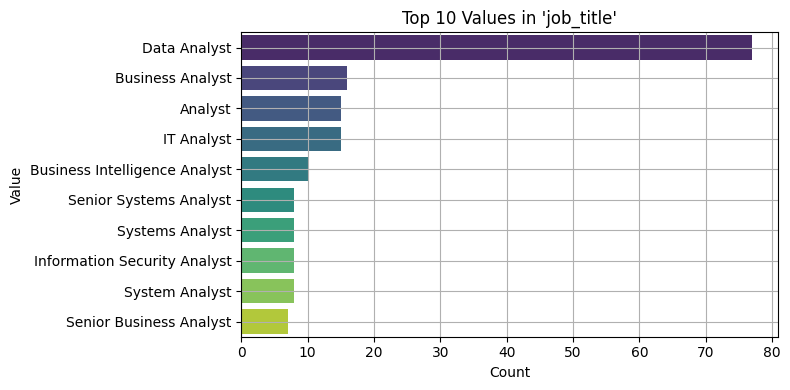

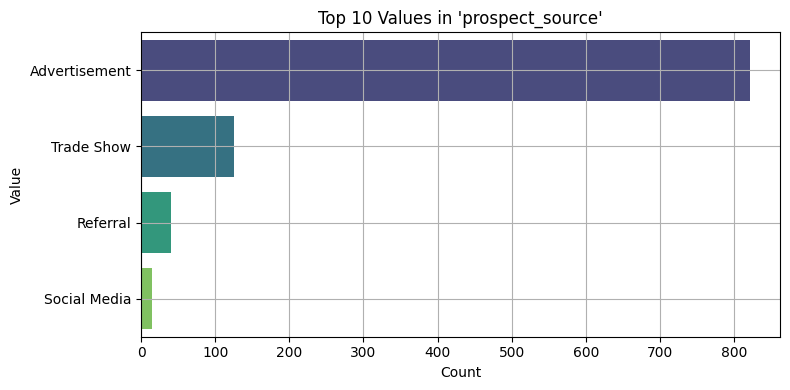

In [ ]:
# Plot the top 10 value counts for each object (string) column
object_cols = df.select_dtypes(include='object').columns
figs = []

for col in object_cols:
    value_counts = df[col].value_counts(dropna=False).head(10)
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.barplot(x=value_counts.values, y=value_counts.index, ax=ax, palette="viridis")
    ax.set_title(f"Top 10 Values in '{col}'")
    ax.set_xlabel("Count")
    ax.set_ylabel("Value")
    ax.grid(True)
    plt.tight_layout()
    figs.append(fig)

# Display all generated plots
for fig in figs:
  fig.show()

## Missing data percentage by column
This analysis provide statistics of missing values by columns in order clarify how many gaps are present in the source spreadsheet.

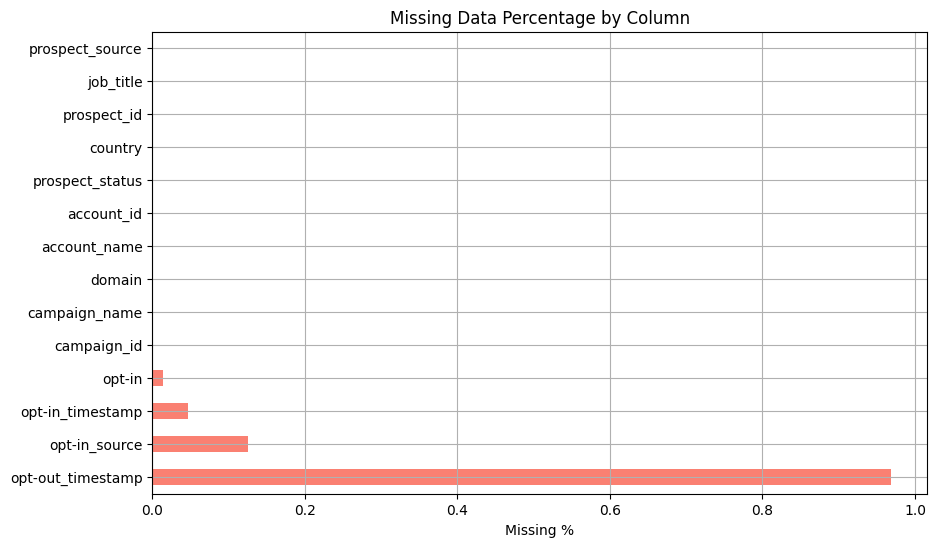

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
df.isnull().mean().sort_values(ascending=False).plot(kind='barh', color='salmon')
plt.title("Missing Data Percentage by Column")
plt.xlabel("Missing %")
plt.grid(True)
plt.show()

## Data cleaning initial strategy
* Format timestamp columns
* Detail and provide granularity for key period columns
* Create quarter flag column in order to classify records
* Create 'opted_out' flag indicating opt-out activity (before dropping timestamps)
* Fill missing values in 'prospect_source' with 'Unknown'
* Create binary 'registered_flag' from 'prospect_status'
* Create 'converted' flag: 1 if prospect_status == "Responded"
* Derive standardized job_role from job_title
* Map prospect_status to funnel stage index
* Save the curated dataset to CSV

In [ ]:
# Convert opt-in and opt-out timestamp columns to datetime format
df['opt_out_timestamp'] = pd.to_datetime(df.get('opt-out_timestamp', None), errors='coerce')
df['opt_in_timestamp'] = pd.to_datetime(df.get('opt-in_timestamp', None), errors='coerce')

#Extract time granularity fields
df['opt_in_year'] = df['opt_in_timestamp'].dt.year
df['opt_in_month'] = df['opt_in_timestamp'].dt.month
df['opt_in_day'] = df['opt_in_timestamp'].dt.day
df['opt_in_hour'] = df['opt_in_timestamp'].dt.hour
df['opt_in_minute'] = df['opt_in_timestamp'].dt.minute

df['opt_out_year'] = df['opt_out_timestamp'].dt.year
df['opt_out_month'] = df['opt_out_timestamp'].dt.month
df['opt_out_day'] = df['opt_out_timestamp'].dt.day
df['opt_out_hour'] = df['opt_out_timestamp'].dt.hour
df['opt_out_minute'] = df['opt_out_timestamp'].dt.minute

# Defining periods
conditions = [
    df['opt_in_month'].isin([1, 2, 3]),
    df['opt_in_month'].isin([4, 5, 6]),
    df['opt_in_month'].isin([7, 8, 9]),
    df['opt_in_month'].isin([10, 11, 12])
]
choices = ['Q1', 'Q2', 'Q3', 'Q4']
df['opt_in_period'] = np.select(conditions, choices, default=None)

# Create 'opted_out' flag indicating opt-out activity (before dropping timestamps)
df['opted_out'] = df['opt_out_timestamp'].notnull()

# Agora podemos remover as colunas de timestamp
df = df.drop(['opt-out_timestamp', 'opt-in_timestamp'], axis=1)

# Fill missing values in 'prospect_source' with 'Unknown'
df['prospect_source'] = df['prospect_source'].fillna('Unknown')

# Create binary 'registered_flag' from 'prospect_status'
df['registered_flag'] = df['prospect_status'].apply(lambda x: 1 if x == 'Registered' else 0)

# Create 'converted' flag: 1 if prospect_status == "Responded"
df['converted'] = df['prospect_status'].apply(lambda x: 1 if str(x).strip().lower() == 'responded' else 0)

# Derive standardized job_role from job_title
def categorize_job_role(title):
    title = str(title).lower()
    if 'manager' in title or 'director' in title:
        return 'Decision Maker'
    elif any(k in title for k in ['vp', 'chief', 'executive']):
        return 'Executive'
    else:
        return 'Practitioner'

df['job_role'] = df['job_title'].apply(categorize_job_role)

# Map prospect_status to funnel stage index
status_map = {'Responded': 1, 'No Show': 2, 'Attended': 3, 'Registered': 4}
df['funnel_stage_index'] = df['prospect_status'].map(status_map)

# Save the curated dataset to CSV
df.to_csv('/content/drive/MyDrive/Notebooks/Accenture/use-case-mkt-04-05-2025/analytics_case_study_curated.csv', header=True, index=False)

In [ ]:
df['funnel_stage_index'].value_counts().plot(kind='bar', title='Funnel Stage Distribution')
plt.show()

## Funnel Conversion Rates
### Goal:
Understand how prospects progress through the marketing funnel:
- **Responded → No Show → Attended → Registered**

### What We Measured:
| Stage       | Count     | Drop-off % |
|-------------|-----------|----------------------|
| Responded   | 94      | 25.98%                    |
| No Show     | 662     | 461.2%                  |
| Attended    | 117     | 27.7%  |
| Registered  | 127     | 0%  |

### Why It Matters:
- Identifies bottlenecks in the conversion journey
- Helps prioritize efforts (e.g., reduce no-shows or improve attended → registered)

In [ ]:
# Count the number of prospects at each funnel stage
funnel_counts = df['prospect_status'].value_counts().reindex(['Responded', 'No Show', 'Attended', 'Registered'])

# Plot the funnel bar chart
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=funnel_counts.index, y=funnel_counts.values, palette="Blues_d")

# Add count labels on top of each bar
for i, v in enumerate(funnel_counts.values):
    ax.text(i, v + 10, str(int(v)), ha='center', fontweight='bold')

# Customize the plot
plt.title("Funnel Stage Distribution")
plt.ylabel("Number of Prospects")
plt.xlabel("Prospect Status")
plt.tight_layout()

# Save or display
plt.savefig("funnel_stage_distribution_labeled.png")  # Save to file
plt.show()  # Display inline (Jupyter/IPython)

## Logistic Regression – Drivers of Registration

### Goal:
Predict the likelihood that a prospect **registers** using key attributes like:
- `job_role`, `prospect_source`, `country`

### How It Works:
- Uses logistic regression to model `P(registered = 1)`
- Outputs coefficients for each feature → shows direction and strength of influence

### Example Insights:
| Feature                    | Coefficient | Insight                           |
|----------------------------|-------------|------------------------------------|
| `job_role_Practitioner`    | +12.72      | Very likely to register            |
| `prospect_source_Referral` | +10.32      | Best channel                       |
| `country_India`            | −9.61       | Negative impact overall            |
| `country_china`            | 6.31       | Best impact overall            |
| `india_practitioner`       | +0.13       | Partially offsets India's weakness |



In [ ]:
features = df[['job_role', 'prospect_source', 'country']]
target = df['registered_flag']
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_encoded = encoder.fit_transform(features)
feature_names = encoder.get_feature_names_out(features.columns)
X_df = pd.DataFrame(X_encoded, columns=feature_names)
X_train, X_test, y_train, y_test = train_test_split(X_df, target, test_size=0.3, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=True)

coef_df.to_csv("/content/drive/MyDrive/Notebooks/Accenture/use-case-mkt-04-05-2025/logistic_regression_table.csv", index=False)

sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='coolwarm')
plt.axvline(0, color='black', linestyle='--')
plt.title("Logistic Regression Coefficients")
plt.tight_layout()
plt.show()

## Chi-Square Test – Prospect Source vs Prospect Status
### Goal:
Check whether **Prospect Source** affects **funnel behavior** (Responded, No Show, Attended, Registered)

### How It Works:
- Builds a **contingency table** of Source × Status
- Tests whether distributions differ **more than expected by chance**

### Result:
- **p-value < 0.05** → Significant association
- Certain sources (e.g., **Referrals**) lead to more Registrations
- Others (e.g., **Social Media**) lead to more No Shows

In [ ]:
contingency = pd.crosstab(df['prospect_source'], df['prospect_status'])
chi2, p, dof, expected = chi2_contingency(contingency)
expected_df = pd.DataFrame(expected, index=contingency.index, columns=contingency.columns)
chi_diff = contingency - expected_df
sns.heatmap(chi_diff, annot=True, fmt=".1f", cmap="coolwarm", center=0)
plt.title("Chi-Square: Observed - Expected")
plt.tight_layout()
plt.show()
print(f"Chi² = {chi2:.2f}, p-value = {p:.4f}, dof = {dof}")
if p < 0.05:
    print("Significant association between Prospect Source and Prospect Status")
else:
    print("No significant association")